In [114]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer
from sklearn.metrics import f1_score, accuracy_score
from torch import nn

from torch.utils.data import DataLoader
from tqdm import tqdm

# Deep Average Network для определения сентимента 

В этой домашке мы будет классифицировать твиты на 3 тональности.  
Вы будете использовать предобученные эмбеддинги слов, так что для начала обязательно нужно посмотреть [туториал по их использованию](https://github.com/BobaZooba/DeepNLP/blob/master/Tutorials/Word%20vectors%20%26%20Data%20Loading.ipynb).

Наши классы:  

Индекс | Sentiment  
-- | --  
0 | negative  
1 | neutral  
2 | positive  

Вам предстоит реализовать такую модель:
![Архитектура модели DAN](https://www.researchgate.net/profile/Shervin-Minaee/publication/340523298/figure/fig1/AS:878252264550411@1586403065555/The-architecture-of-the-Deep-Average-Network-DAN-10.ppm)

Что она из себя представляет:
- Мы подаем в нее индексы слов
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`

В этой домашке вам предстоит:
- Перевести тексты в матрицы с индексами токенов
- Реализовать модель
- Обучить ее
- Понять хорошо ли вы это сделали

Это очень важная модель, потому что она очень простая и показывает достаточно высокие метрики. В дальнейшем на работе советую использовать такую модель как бейзлайн. И в качестве эмбеддингов слов взять эмбеддинги от берта/роберты/тд.

## 🤗 Datasets
В этом туториале мы будем использовать подготовленные данные из библиотеки [datasets](https://github.com/huggingface/datasets). Мы вряд ли еще будем пользоваться этой библиотекой, так как нам будет важно самим подготавливать данные. Во-первых, для простоты, во-вторых, здесь есть достаточно неплохие практики. [Здесь](https://huggingface.co/datasets) вы сможете найти достаточно большое количество различных датасетов. Возможно, когда-нибудь они вам пригодятся.

## Загрузите эмбеддинги слов
Реализуйте функцию по загрузке эмбеддингов из файла. Она должна отдавать словарь слов и `np.array`
Формат словаря:
```python
{
    'aabra': 0,
    ...,
    'mom': 6546,
    ...
    'xyz': 100355
}
```
Формат матрицы эмбеддингов:
```python
array([[0.44442278, 0.28644582, 0.04357426, ..., 0.9425766 , 0.02024289,
        0.88456545],
       [0.77599317, 0.35188237, 0.54801261, ..., 0.91134102, 0.88599103,
        0.88068835],
       [0.68071886, 0.29352313, 0.95952505, ..., 0.19127958, 0.97723054,
        0.36294011],
       ...,
       [0.03589378, 0.85429694, 0.33437761, ..., 0.39784873, 0.80368014,
        0.76368042],
       [0.01498725, 0.78155695, 0.80372969, ..., 0.82051826, 0.42314861,
        0.18655465],
       [0.69263802, 0.82090775, 0.27150426, ..., 0.86582747, 0.40896573,
        0.33423976]])
```

Количество строк в матрице эмбеддингов должно совпадать с размером словаря, то есть для каждого токена должен быть свой эмбеддинг. По параметру `num_tokens` должно брать не более указано в этом параметре количество токенов в словарь и матрицу эмбеддингов.

In [2]:
# Раскомментируйте и скачайте эмбеддинги
# !wget  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
# !gzip -d cc.ru.300.vec.gz

In [3]:
token2index: Dict[str, int] = {}
embeddings_matrix: np.array = []

with open("small.vec", "r") as f:
    lines = f.readlines()
    for idx, line in enumerate(lines):
        if idx == 0: continue
        line = line.split(" ")
        word, embedd = line[0],  line[1:]
        
        token2index[word] = idx-1
        embeddings_matrix.append(embedd)



In [4]:
len(token2index)

50001

In [5]:
np.array(embeddings_matrix, dtype=float)

array([[-3.260e-02, -1.499e-01,  2.320e-02, ..., -2.370e-02, -2.610e-02,
        -1.832e-01],
       [-5.550e-02, -1.750e-02,  9.360e-02, ...,  2.010e-02,  5.350e-02,
        -3.563e-01],
       [-3.120e-02, -6.270e-02,  3.260e-02, ...,  3.980e-02, -2.425e-01,
        -2.647e-01],
       ...,
       [-9.850e-02,  1.093e-01,  2.700e-03, ...,  1.690e-02,  7.030e-02,
        -1.731e-01],
       [ 1.390e-02, -3.000e-04,  1.390e-02, ..., -4.080e-02, -5.100e-03,
        -7.100e-03],
       [ 4.100e-03, -1.090e-02,  1.750e-02, ...,  4.300e-02, -6.870e-02,
        -1.900e-02]])

In [6]:
def load_embeddings(path, num_tokens=100_000):

    # Необязательно задавать здесь
    # Это рекомендация к типу
    token2index: Dict[str, int] = {}
    embeddings_matrix: np.array = []
    pad_token = 'PAD'
    unk_token = 'UNK'

    token2index[pad_token] = 0
    embeddings_matrix.append(np.zeros(300))

    token2index[unk_token] = 1
    embeddings_matrix.append(np.zeros(300))
            
    with open(path, "r") as f:
        lines = f.readlines()
    
    for idx, line in tqdm(enumerate(lines)):
        if idx < 2: continue
        line = line.split(" ")
        word, embedd = line[0],  line[1:]
        
        token2index[word] = idx-1
        embeddings_matrix.append(embedd)

    embeddings_matrix = np.array(embeddings_matrix, dtype=float)
    assert(len(token2index) == embeddings_matrix.shape[0])
    
    return token2index, embeddings_matrix

In [7]:
# уменьшаю размер эмбеддингов, чтобы не залезло в память
token2index, embeddings_matrix = load_embeddings("small.vec")

50002it [00:01, 35369.73it/s]


## Загружаем данные из библиотеки
Мы сразу получим `torch.utils.data.Dataset`, который сможем передать в `torch.utils.data.DataLoader`

In [8]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Found cached dataset tweet_eval (/home/jovyan/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Found cached dataset tweet_eval (/home/jovyan/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Found cached dataset tweet_eval (/home/jovyan/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


## `torch.utils.data.DataLoader`

In [59]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Посмотрим что отдает нам `Loader`
Это батч формата:
```python
batch = {
    "text": [
        "text1",
        "text2",
        ...,
        "textn"
    ],
    "label": tensor([
        1,
        1,
        ...,
        0
    ])
}
```
То есть у нас есть словарь с двумя ключами `text` и `label`, где хранится n примеров. То есть для 5-го примера в батче текст будет храниться в `batch["text"][5]`, а индекс класса будет храниться в `batch["label"][5]`.

In [10]:
for batch in train_loader:
    break

batch

{'text': ["Fynn's 9th Birthday is coming up, would it be too early to buy him the first Harry Potter book???",
  'Exciting weekend. Kitchen being fitted today Foo Fighters live tomorrow. Iggy Pop and Royal Blood supporting is the icing on the cake'],
 'label': tensor([1, 2])}

## Collate
Сейчас перед нами стоит проблема: мы получаем тексты в виде строк, а нам нужны тензоры (матрицы) с индексами токенов, к тому же нам нужно западить последовательности токенов, чтобы все сложить в торчовую матрицу. Мы можем сделать это двумя способами:
- Достать из `train/valid/test_dataset` данные и написать свой `Dataset`, где внутри будет токенизировать текст, токены будут переводиться в индексы и затем последовательность будет падиться до нужной длины
- Сделать функцию, которая бы дополнительно обрабатывали наши батчи. Она вставляется в `DataLoader(collate_fn=<ВАША_ФУНКЦИЯ>)`

## Если вы хотите сделать `collate_fn`

## Формат батча
```python
batch = [
    {
        "text": "text1",
        "label": 0
    }, 
    {
        "text": "text2",
        "label": 1
    },
    ...,
    {
        "text": "textn",
        "label": 1
    }
]
```
То есть теперь у нас есть список, где каждый элемент — это словарь со значениями `text` и `label`.  

Вы можете сделать функцию или класс с методом `collate`. Этот способ решения домашки предодчтительней, так как использовать `collate` очень хорошая практика.

Что я предлагаю:
- Сделайте класс `Tokenizer`

In [109]:
class Tokenizer:
    
    def __init__(self, token2index, pad_token, unk_token, max_length):
        
        self._base_tokenizer = ToktokTokenizer()  # например ToktokTokenizer()
        
        self.token2index = token2index  # словарь из load_embeddings()
        
        self.pad_token = pad_token
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = unk_token
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length

    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        """
        return self._base_tokenizer.tokenize(text)
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        """
        token_indices = list()
        for i, v in enumerate(tokenized_text):
            if v in self.token2index:
                token_indices.append(self.token2index[v])
            else:
                token_indices.append(self.unk_index)
        return token_indices
        
    def padding(self, tokens_indices):
        """
        В этом методе нужно сделать длину tokens_indices равной self.max_length
        Опционально убрать повторяющиеся unk'и
        """
        if len(tokens_indices) > self.max_length:
            tokens_indices = tokens_indices[:self.max_length]
       
        if len(tokens_indices) < self.max_length:
            tokens_indices = tokens_indices + np.zeros(self.max_length - len(tokens_indices), dtype=int).tolist()

        return tokens_indices

    
    def __call__(self, text):
        """
        В этом методе нужно перевести строку с текстом в вектор с индексами слов нужно размера (self.max_length)
        """
        tokenized_text = self.tokenize(text)
        tokens_indices = self.indexing(tokenized_text)
        tokens_indices = self.padding(tokens_indices)
        return tokens_indices
       

        
    def collate(self, batch):
        
        tokenized_texts = list()
        labels = list()
        
        for sample in batch:
            tokenized_texts.append(self.__call__(sample["text"]))
            labels.append(sample["label"])


        tokenized_texts = torch.tensor(tokenized_texts) # перевод в torch.Tensor
        labels = torch.tensor(labels) # перевод в torch.Tensor
        
        return tokenized_texts, labels

## Перед реализацией выбранного метода
Советую, чтобы в итоге `Loader` отдавал кортеж с двумя тензорами:
- `torch.Tensor` с индексами токенов, размерность `(batch_size, sequence_length)`
- `torch.Tensor` с индексами таргетов, размерность `(batch_size)`

То есть, чтобы было так:
```python
for x, y in train_loader:
    ...

>> x
>> tensor([[   37,  3889,   470,  ...,     0,     0,     0],
           [ 1509,   581,   144,  ...,     0,     0,     0],
           [ 1804,   893,  2457,  ...,     0,     0,     0],
           ...,
           [  170, 39526,  2102,  ...,     0,     0,     0],
           [ 1217,   172, 28440,  ...,     0,     0,     0],
           [   37,    56,   603,  ...,     0,     0,     0]])

>> y
>> tensor([1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1,
           0, 2, 1, 1, 0, 1, 2, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0,
           1, 0, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0, 2, 1, 2, 2, 1, 0, 0, 2, 2,
           2, 1, 2, 0, 2, 2, 0, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2,
           2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1,
           2, 1, 1, 2, 2, 1, 1, 2])

>> x.shape
>> torch.Size([128, 64])

>> y.shape
>> torch.Size([128])
```
При условии, что батч сайз равен 128, а максимальная длина последовательности равна 64.

## Помните

## <Место для реализации>

In [110]:
tokenizer = Tokenizer(token2index, 'PAD', 'UNK', 100)

In [111]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)

In [112]:
for x, y in train_loader:
    break

In [63]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

# Реализация DAN

На вход модели будут подавать индексы слов

Шаги:
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`
    - Нужно реализовать самому

### Что нужно сделать в домашке с точки зрения архитектуры сети:
- Реализовать skip-connection (residual connection) в линейном слое
- Написать свой слой, в котором будут (порядок слоев ниже напутан, так что сами подумайте в каком порядке стоит расположить эти слои) :
  - `Dropout`
  - `BatchNorm` / `LayerNorm`
  - `Residual`, если вы не меняете размерность векторов
  - Функция активации
  - Линейный слой

### Опциональные задания:
- Использовать токенизатор и слой эмбеддингов от предобученного трансформера из библиотеки `transformers`
- Сделать усреднение эмбеддингов с учетом падов
  - Мы используем пады, чтобы сделать единую длину последовательностей в батче
    - То есть у нас максимальная длина в батче, например, 16 токенов, поэтому ко всем последовательностям, у которых длина ниже мы добавляем `16 - len(sequence)` падов
  - То есть получается так, что усредненный вектор предложения зависит от максимальный длины в батче, потому что
    - Среднее вектора `[1, 2, 3]` будет `2`. Среднее вектора `[1, 2, 3, 0, 0]` будет `1.2`
    - Получается, что усредняя с падами мы получаем "неправильный" вектор
  - То есть наши предсказания будут зависеть от того сколько падов у нас есть в предложении
  - Когда мы будем использовать нашу сетку в реальном процессе, скорее всего, мы будем подавать в нее по одному примеру, где падов не будет
    - То есть получается мы будем использовать нашу модель не в той же среде, как и обучали
      - Потому что наши входы меняются, мы не используем пады, результат усреднения другой
    - Это называется `distribution shift`, то есть когда мы учимся на одних данных, а используем на других
      - Это не всегда плохо, потому что иногда только так мы и можем учиться, например, когда мало данных нужного домена
      - Это плохо тогда, когда мы вносим это "случайно", например, как с неправильным усреднением, то есть это своебразный баг


## До обучения
- Выберите метрику(ки) качества и расскажите почему она(они)
    - Обычно есть основная метрика, по которой принимаем решения какие веса брать и дополнительные, которые нам помогут делать выводы, например, о том все ли хорошо с нашими данными, хорошо ли модель справляется с дисбалансом классов и тд
- Эту домашку можно сделать и на `CPU`, но на `GPU` будет сильно быстрее
    - Во всех остальных домашках мы будем учить модели на `GPU`
    - Рано или поздно вам придется посмотреть этот [туториал](https://www.youtube.com/watch?v=pgk1zGv5lU4)
    - Вы можете обучаться на `colab`, это бесплатно

## До эпохи
- Сделайте списки/словари/другое, чтобы сохранять нужные данные для расчета метрик(и) по всей эпохе для трейна и валидации

## Во время эпохи
- Используйте [`tqdm`](https://github.com/tqdm/tqdm) как прогресс бар, чтобы понимать как проходит ваше обучение
- Логируйте лосс
- Логируйте метрику(ки) по батчу
- Сохраняйте то, что вам нужно, чтобы посчитать метрик(и) на всю эпоху для трейна и валидации

## После эпохи
- Посчитайте метрик(и) на всю эпоху для трейна и валидации

## После обучения
- Провалидируйтесь на тестовом наборе и посмотрите метрики
- Постройте [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- Постройте графики:
    - [Confusion Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)
    - [Опционально] Распределение вероятностей мажоритарного класса (то есть для какого-то примера мы выбираем такой класс и вероятность этого выбора такая-то) на трейне/тесте/валидации
        - Если класс был выбран верно и если была ошибка
- Подумайте что еще вам будет полезно для того, чтобы ответить на такие вопросы: 
    - Что в моделе можно улучшить?
    - Все ли хорошо с моими данными?
    - Все ли хорошо с валидацией?
    - Не переобучился ли я?
    - Достаточно ли я посмотрел на данные?
    - Нужно ли мне улучшить предобработку данных?
    - Нужно ли поменять токенизацию или эмбеддинги?
    - Нет ли у меня багов в реализации?
    - Какие типичные ошибки у моей модели?
    - Как я могу их исправить?

# Я выбрала метрику f1 score

f1 score - это среднее гармоническое precision и recall. Она показывает, насколько точно модель предсказывает  и положительные, и отрицательные классы. Таким образом, f1 score - это хороший индикатор того, насколько хорошо модель работает в целом. Часто используется для мультиклассовой классификации.

In [113]:
class DeepAverageNetwork(nn.Module):
    def __init__(self):
        super(DeepAverageNetwork, self).__init__()
        self.emb_layer = torch.nn.Embedding.from_pretrained(torch.FloatTensor(embeddings_matrix))
        self.embedding_length = embeddings_matrix.shape[-1]
        self.relu = torch.nn.ReLU()

        self.fc1 = nn.Linear(self.embedding_length, self.embedding_length)
        self.fc2 = nn.Linear(self.embedding_length, self.embedding_length)
        self.fc3 = nn.Linear(self.embedding_length, self.embedding_length)
        self.fc4 = nn.Linear(self.embedding_length, self.embedding_length)
        self.fc5 = nn.Linear(self.embedding_length, self.embedding_length)

        self.classifier = torch.nn.Sequential(
            torch.nn.BatchNorm1d(self.embedding_length),
            torch.nn.Linear(self.embedding_length, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3),
            torch.nn.Dropout(0.2),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, inputs):

        x = self.emb_layer(inputs)
        x = x.mean(dim=1)

        x1 = self.fc1(x)
        x1 = self.relu(x1)
        
        x2 = self.fc2(x1)
        x2 = self.relu(x2)
     
        x3 = self.fc3(x2)
        x3 = self.relu(x3)

        x4 = self.fc4(x3+x2) # skip connection
        x4 = self.relu(x4)
        
        x5 = self.fc5(x4+x1) # skip connection
        return self.classifier(x)

In [93]:
model = DeepAverageNetwork()

## Задайте функцию потерь и оптимизатор

In [94]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

## Сделайте цикл обучения

In [126]:
epochs = 10
losses = []


for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    val_losses = []
    f1_scores = []
    test_preds = []
    test_targets = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1)
        
        optimizer.zero_grad()
        
        pred = model(x)
        
        loss = loss_fn(pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-100:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()

    for x, y in valid_loader:
            
            x = x.view(x.shape[0], -1)
            
            pred = model(x)
            
            loss = loss_fn(pred, y)
            
            val_losses.append(loss.item())
            
            pred_labels = np.argmax(pred.detach().numpy(), axis=-1)
            f1_scores.append(f1_score(pred_labels, y.detach().numpy(), average="micro"))
    mean_f1_score = sum(f1_scores) / len(f1_scores)
    
    
    for x, y in test_loader:
        
        x = x.view(x.shape[0], -1)

        with torch.no_grad():
            
            pred = model(x)
            
        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())

        loss = loss_fn(pred, y)

        test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)
        
    print('Losses: train = {:.3f}, val = {:.3f}, test = {:.3f}; f1_score = {:.3f}'.format(np.mean(train_losses), np.mean(val_losses), mean_test_loss, mean_f1_score))

Epoch 1: 100%|██████████| 45615/45615 [00:09<00:00, 4837.67it/s, train_loss=0.838]


Losses: train = 0.836, val = 1.011, test = 1.088; f1_score = 0.522


Epoch 2: 100%|██████████| 45615/45615 [00:08<00:00, 5188.16it/s, train_loss=0.844]


Losses: train = 0.838, val = 1.010, test = 1.077; f1_score = 0.523


Epoch 3: 100%|██████████| 45615/45615 [00:11<00:00, 4078.87it/s, train_loss=0.84] 


Losses: train = 0.833, val = 1.007, test = 1.070; f1_score = 0.524


Epoch 4: 100%|██████████| 45615/45615 [00:12<00:00, 3544.28it/s, train_loss=0.834]


Losses: train = 0.832, val = 1.013, test = 1.070; f1_score = 0.523


Epoch 5: 100%|██████████| 45615/45615 [00:13<00:00, 3275.07it/s, train_loss=0.837]


Losses: train = 0.828, val = 1.008, test = 1.082; f1_score = 0.527


Epoch 6: 100%|██████████| 45615/45615 [00:09<00:00, 4972.13it/s, train_loss=0.834]


Losses: train = 0.826, val = 1.008, test = 1.065; f1_score = 0.525


Epoch 7: 100%|██████████| 45615/45615 [00:08<00:00, 5244.42it/s, train_loss=0.827]


Losses: train = 0.823, val = 1.008, test = 1.067; f1_score = 0.527


Epoch 8: 100%|██████████| 45615/45615 [00:09<00:00, 4877.54it/s, train_loss=0.825]


Losses: train = 0.821, val = 1.011, test = 1.070; f1_score = 0.526


Epoch 9: 100%|██████████| 45615/45615 [00:09<00:00, 5068.20it/s, train_loss=0.83] 


Losses: train = 0.820, val = 1.011, test = 1.079; f1_score = 0.531


Epoch 10: 100%|██████████| 45615/45615 [00:09<00:00, 4932.42it/s, train_loss=0.824]


Losses: train = 0.820, val = 1.008, test = 1.076; f1_score = 0.532


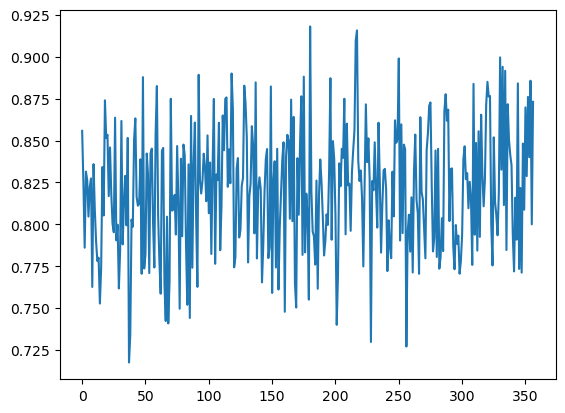

In [133]:
plt.plot(train_losses)

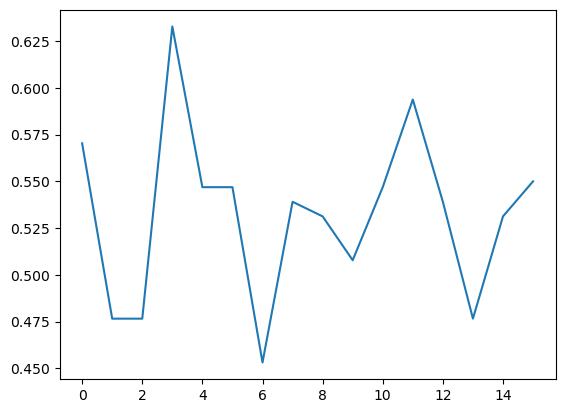

In [132]:
plt.plot(f1_scores)

In [134]:
from sklearn.metrics import classification_report

f1_tmp = []
model.eval()

predict_values = []
true_values = []

for x, y in test_loader:
    test_pred = model(x)
    pred_labels = np.argmax(test_pred.detach().numpy(), axis=-1)
    predict_values.extend(pred_labels)
    true_values.extend(y.detach().numpy())

print(classification_report(predict_values, true_values))

              precision    recall  f1-score   support

           0       0.13      0.51      0.20       992
           1       0.66      0.54      0.59      7155
           2       0.53      0.31      0.39      4137

    accuracy                           0.46     12284
   macro avg       0.44      0.45      0.40     12284
weighted avg       0.57      0.46      0.49     12284



# Выводы
Напишите небольшой отчет о проделанной работе. Что удалось, в чем не уверены, что делать дальше.

По саппорту в `classification_report` видно, что есть дисбаланс классов: гораздо больше примеров класса 1, который и имеет самые высокие показатели всех метрик. Вероятно, это произошло из-за того, что я взяла не все данные, а только четверть.

Никие показатели всех метрик в целом могут быть объяснены качеством эмбеддингов. Можно попробовать взять другие предобученные эмбеддинги и посмотреть на изменение метрик.

Также известно residual connection оригинально использовался для сохранения структуры изображения в задаче сегментации изображений. Поэтому есть мнение, что в задаче классификации текстов это может быть не очень уместно. Можно попробовать обучить модель без residual connection и посмотреть, как это повлияет на метрики.